In [1]:
import ironman
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt
import rmfit
from astropy import units as u
from astropy import constants as c
import juliet
from astropy.timeseries import LombScargle

In [2]:
#from matplotlib import rc
#rc('font', **{'family':'sans-serif'}) Use only if you have pdflatex (recommended)
#rc('text', usetex=True)

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0

In [3]:
dataset = juliet.load(input_folder = 'TOI-2431_juliet_1', out_folder = 'TOI-2431_juliet_1')
results = dataset.fit(sampler = "dynamic_dynesty")

Detected dynamic_dynesty sampler output files --- extracting from TOI-2431_juliet_1/_dynesty_DNS_posteriors.pkl


In [4]:
#results.nested_sampling.results.logz[-1]

In [5]:
P = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['P_p1'])[0]
t0 = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['t0_p1'])[0]
print(P,t0)

0.22419577726511994 2460258.8685490405


# Photometry

In [6]:
def plot_with_gp(instrument, title, name, P, t0):
    global results
    x = dataset.times_lc[instrument]
    phases = juliet.utils.get_phases(dataset.times_lc[instrument], P, t0)
    transit_plus_GP = results.lc.evaluate(instrument)
    transit_model = results.lc.model[instrument]['deterministic']
    gp_model = results.lc.model[instrument]['GP']

    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument]) / 1e6
    
    mask = np.logical_or(np.logical_and(phases>-0.05,phases<-0.02),np.logical_and(phases<0.05,phases>0.02))
    #print(mask)
    oot = (dataset.data_lc[instrument] - gp_model)[mask]
    m_inst = 1-np.mean(oot)
    
    # print(x)
    # print(phases)
    # print(transit_plus_GP)
    # print(transit_model)
    # print(gp_model)
    # print(jitter)
    
    #m_inst = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['mflux_'+instrument])[0]
    transit_model = results.lc.model[instrument]['deterministic']
    
    fig, ax = plt.subplots(dpi=100)
    plt.errorbar(phases,dataset.data_lc[instrument]-gp_model+m_inst,yerr = np.sqrt(dataset.errors_lc[instrument]**2.0 + jitter**2.0), fmt = '.', alpha = 0.7)

    idx = np.argsort(phases)
    plt.plot(phases[idx],transit_model[idx], color='black',zorder=10)

    plt.xlim([-0.5,0.5])
    #plt.ylim([0.98,1.02])
    plt.title(title)
    #plt.xlim()
    #plt.ylim([0.995,1.005])
    plt.xlabel('Phase')
    plt.ylabel('Relative flux')
    plt.show()

    return phases, dataset.data_lc[instrument], np.sqrt(dataset.errors_lc[instrument]**2.0 + jitter**2.0), transit_model, m_inst, gp_model

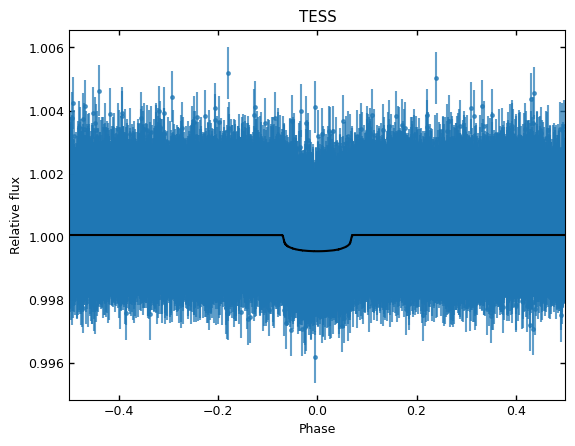

In [7]:
phase_tess, flux_tess, flux_err_tess, model_tess, m_tess, gp_model_tess = plot_with_gp("TESS","TESS","TESS_det.csv",P,t0)

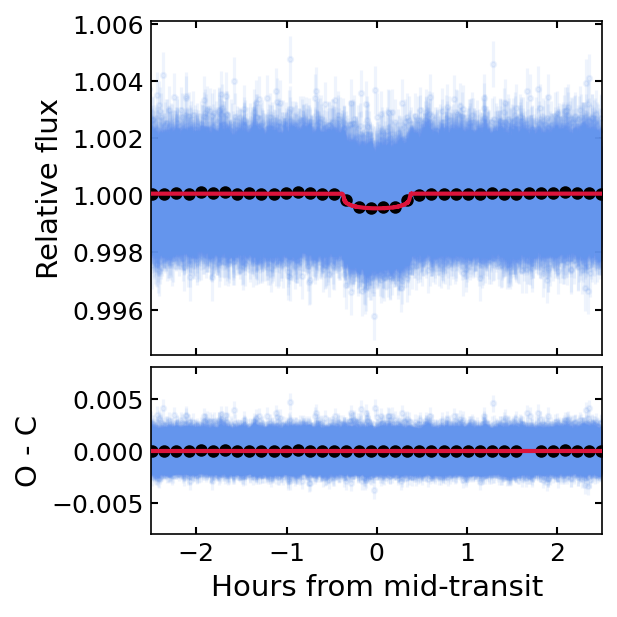

In [8]:
def bin_lc(phase, f, num_bins=40):
    # Shift phase from [-0.5, 0.5] to [0, 1] for binning
    phase = np.mod(phase + 1, 1)

    # Define bin edges and centers
    bin_edges = np.linspace(0, 1, num_bins + 1)
    binned_phase = (bin_edges[:-1] + bin_edges[1:]) / 2
    binned_flux = np.full(num_bins, np.nan)  # Initialize with NaNs

    for i in range(num_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i + 1])
        if np.any(mask):
            binned_flux[i] = np.mean(f[mask])  # Mean flux in bin

    # Convert phase back to [-0.5, 0.5] for correct plotting
    binned_phase = binned_phase - (binned_phase > 0.5)

    return binned_phase, binned_flux

fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

phase_bin, flux_bin = bin_lc(phase_tess, flux_tess)

ax1.errorbar(phase_tess*P*24.,flux_tess-gp_model_tess,flux_err_tess,fmt = '.', alpha=0.1,color="cornflowerblue")
idx = np.argsort(phase_tess)
ax1.plot(phase_tess[idx]*P*24.,model_tess[idx], color='crimson',zorder=10,lw=2)

ax1.plot((phase_bin)*P*24.,flux_bin,"o",color="k",zorder=5)

#ax1.set_ylim()
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Relative flux',fontsize=14)

res = flux_tess-gp_model_tess-model_tess

phase_res_bin, res_bin = bin_lc(phase_tess, res)

ax2.errorbar(phase_tess*P*24.,res,flux_err_tess,fmt = '.', alpha=0.1,color="cornflowerblue")
ax2.axhline(0.0,lw=2,color="crimson",zorder=30)
ax2.plot((phase_bin)*P*24.,res_bin,"o",color="k",zorder=5)

ax2.set_xlim(-2.5,2.5)
ax2.set_ylim(-0.008,0.008)
#ax2.set_xticks([-2,-1,0,1,2,3])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=14)
ax2.set_ylabel('O - C', fontsize = 14)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

fig.set_facecolor('w')
#plt.tight_layout()
#fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.07),ncol=6, fancybox=True, fontsize=9)
plt.savefig("TOI-2431_PHOT.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

# Radial Velocities

In [9]:
def plot_rv(inst):

    global results
    global dataset
    
    fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)
    
    min_time, max_time = np.min(dataset.times_rv[inst])-10,\
                         np.max(dataset.times_rv[inst])+10
    
    model_times = np.linspace(min_time,max_time,100000)
    
    keplerian = results.rv.evaluate(inst, t = model_times) - np.median(results.posteriors['posterior_samples']['mu_'+inst])
    
    color = 'cornflowerblue'
    
    # Evaluate the median jitter for the instrument:
    jitter = 0
    # Evaluate the median systemic-velocity:
    mu = np.median(results.posteriors['posterior_samples']['mu_'+inst])

    # Plot original errorbars + jitter (added in quadrature):
    plt.errorbar(dataset.times_rv[inst]-2457000,dataset.data_rv[inst]-mu,\
                 yerr = np.sqrt(dataset.errors_rv[inst]**2+jitter**2),fmt='o',\
                 mec=color, ecolor=color, mfc = 'white', label=inst,\
                 alpha = 0.5, zorder=5)
    
    # Plot Keplerian model:
    plt.plot(model_times-2457000, keplerian,color='black',zorder=1)
    plt.ylabel('RV (m/s)', fontsize = 11)
    plt.xlabel('Time (BJD - 2457000)', fontsize = 11)
    plt.show()

    keplerian = results.rv.evaluate(inst, t = dataset.times_rv[inst]) - np.median(results.posteriors['posterior_samples']['mu_'+inst])

    return dataset.times_rv[inst], dataset.data_rv[inst], np.sqrt(dataset.errors_rv[inst]**2+jitter**2), mu, keplerian

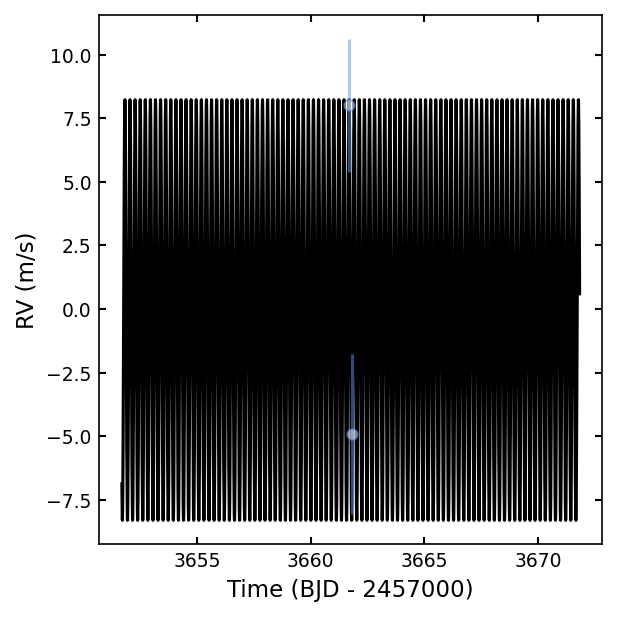

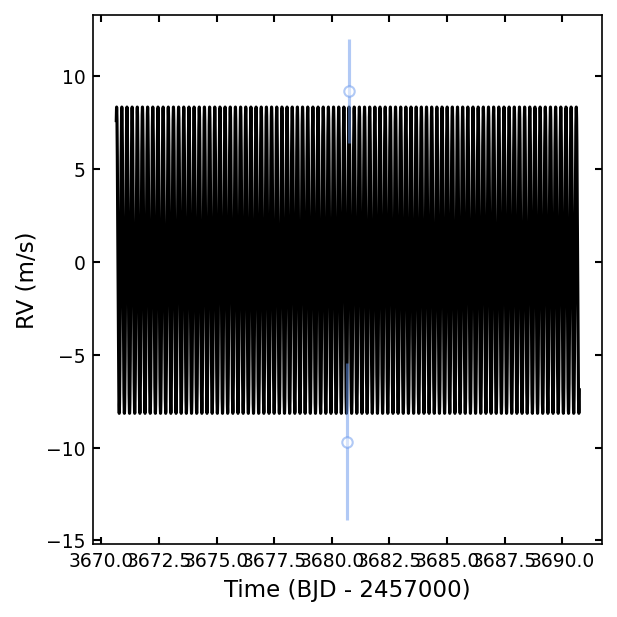

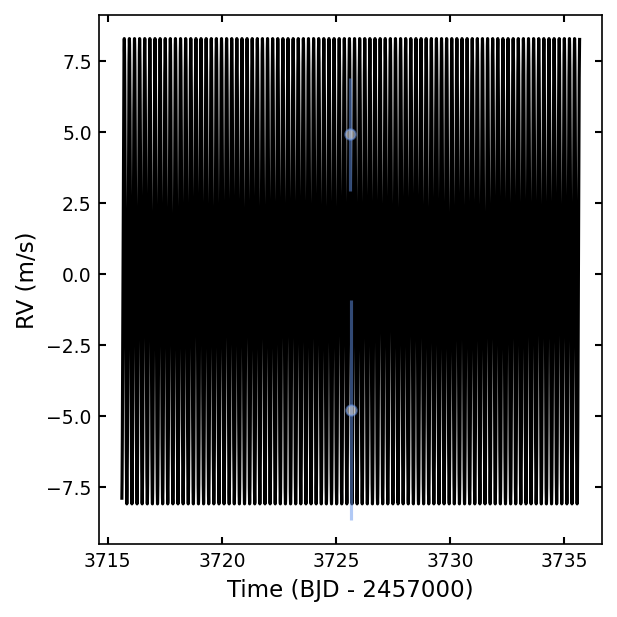

In [10]:
times_neid1, rv_neid1, rv_err_neid1, gamma_neid1, model_neid1 =  plot_rv("NEID1")
times_neid2, rv_neid2, rv_err_neid2, gamma_neid2, model_neid2 =  plot_rv("NEID2")
times_neid3, rv_neid3, rv_err_neid3, gamma_neid3, model_neid3 =  plot_rv("NEID3")

In [11]:
min_time, max_time = np.min(dataset.times_rv["NEID1"]),np.max(dataset.times_rv["NEID3"])
model_times = np.linspace(min_time-10,max_time+10,5000)    
keplerian = results.rv.evaluate("NEID1", t = model_times, nsamples = 5000, return_samples = True)[0] - np.median(results.posteriors['posterior_samples']['mu_NEID1'])

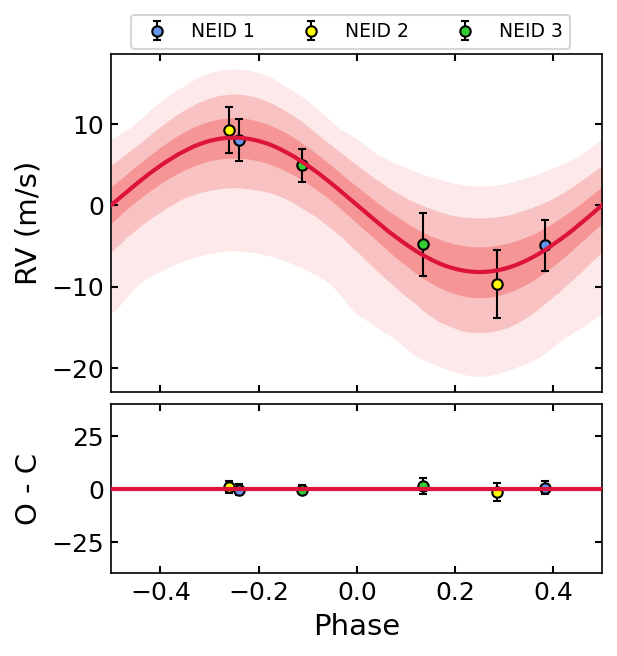

In [12]:
fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

phase_model = (((model_times-t0 + 0.5*P) % P)/P) - 0.5
phase_neid1 = (((times_neid1-t0 + 0.5*P) % P)/P) - 0.5
phase_neid2 = (((times_neid2-t0 + 0.5*P) % P)/P) - 0.5
phase_neid3 = (((times_neid3-t0 + 0.5*P) % P)/P) - 0.5

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=14)

ax1.errorbar(phase_neid1,rv_neid1-gamma_neid1,rv_err_neid1,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue",label="NEID 1")
ax1.errorbar(phase_neid2,rv_neid2-gamma_neid2,rv_err_neid2,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="yellow",label="NEID 2")
ax1.errorbar(phase_neid3,rv_neid3-gamma_neid3,rv_err_neid3,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="limegreen",label="NEID 3")
idx = np.argsort(phase_model)
ax1.plot(phase_model[idx],np.quantile(keplerian,0.5,axis=0)[idx],lw=2,color="crimson",zorder=20)
ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.16,axis=0)[idx],np.quantile(keplerian,0.84,axis=0)[idx],alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.02,axis=0)[idx],np.quantile(keplerian,0.98,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1)
ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.0015,axis=0)[idx],np.quantile(keplerian,0.9985,axis=0)[idx],alpha=0.1,color="#EE2C2C",lw=0,zorder=-1)

res_neid1 = rv_neid1-gamma_neid1-model_neid1
res_neid2 = rv_neid2-gamma_neid2-model_neid2
res_neid3 = rv_neid3-gamma_neid3-model_neid3

ax2.errorbar(phase_neid1,res_neid1,rv_err_neid1,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax2.errorbar(phase_neid2,res_neid2,rv_err_neid2,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="yellow")
ax2.errorbar(phase_neid3,res_neid3,rv_err_neid3,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="limegreen")
ax2.axhline(0.0,lw=2,color="crimson",zorder=30)

ax2.set_xlim(-0.5,0.5)
ax2.set_ylim(-40,40)
ax2.set_yticks([-25,0,25])
ax2.set_xlabel(r'Phase',fontsize=14)
ax2.set_ylabel('O - C', fontsize = 14)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

fig.set_facecolor('w')
#plt.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.57, 1.07),ncol=6, fancybox=True, fontsize=9)
plt.savefig("TOI-2431_RVs_phase.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [13]:
def get_vals(vec):
    fvec   = np.sort(vec)

    fval  = np.median(fvec)
    nn = int(np.around(len(fvec)*0.15865))

    vali,valf = fval - fvec[nn],fvec[-nn] - fval
    return fval,vali,valf
    
def print_mass_radius_rho_sma_planet(rstar=1.0, rstar_err=0.1, mstar=1.0, mstar_err=0.1, r_units=u.Rjup, sma_units=u.AU, m_units=u.Mjup):
    """
    Calculate and print the planet's mass, radius, density, and semi-major axis. If r_star and/or m_star are not sampled they must be added as inputs

    Parameters:
    rstar (float) optional: Mean stellar radius in solar radii. Only if r_star not sampled
    rstar_err (float) optional: Error in stellar radius. Only if r_star not sampled
    mstar (float) optional: Mean stellar mass in solar masses. Only if m_star not sampled
    mstar_err (float) optional: Error in stellar mass. Only if m_star not sampled
    r_units (Astropy Unit): Desired output units for the planet's radius.
    sma_units (Astropy Unit): Desired output units for the semi-major axis.
    m_units (Astropy Unit): Desired output units for the planet's mass.
    """
    # chain = self.fit.chain
    Rs = np.random.normal(rstar, rstar_err, len(results.posteriors['posterior_samples']['K_p1'])) * u.Rsun
    Ms = np.random.normal(mstar, mstar_err, len(results.posteriors['posterior_samples']['K_p1'])) * u.Msun

    rp = results.posteriors['posterior_samples']['p_p1'] * Rs
    rp = rp.to(r_units)
    r_planet_val, r_planet_down, r_planet_up = get_vals(rp.value)
    print(f"R_planet: {r_planet_val:.4f} +{r_planet_up:.4f} -{r_planet_down:.4f} {r_units}")

    aRs = 2.2880303471 * Rs
    sma = aRs.to(sma_units)
    sma_val, sma_down, sma_up = get_vals(sma.value)
    print(f"Sma_planet: {sma_val:.4f} +{sma_up:.4f} -{sma_down:.4f} {sma_units}")

    K = results.posteriors['posterior_samples']['K_p1'] * u.m / u.s
    e = 0
    inc = 90 * np.pi / 180.0  # Convert to radians
    mp = K * np.sqrt(Ms * sma * (1 - e**2) / c.G) / np.sin(inc)
    mp = mp.to(m_units)
    m_planet_val, m_planet_down, m_planet_up = get_vals(mp.value)
    print(f"M_planet: {m_planet_val:.4f} +{m_planet_up:.4f} -{m_planet_down:.4f} {m_units}")

    dens = (3 * mp / (4 * np.pi * rp**3)).to(u.g / u.cm**3)
    dens_val, dens_down, dens_up = get_vals(dens.value)
    print(f"Rho_planet: {dens_val:.4f} +{dens_up:.4f} -{dens_down:.4f} g/cm^3")

In [14]:
print_mass_radius_rho_sma_planet(rstar=0.66,rstar_err=0.01,mstar=0.66,mstar_err=0.02,r_units=u.Rearth,m_units=u.Mearth)

R_planet: 1.5159 +0.0602 -0.0467 earthRad
Sma_planet: 0.0070 +0.0001 -0.0001 AU
M_planet: 6.2627 +1.3752 -1.2687 earthMass
Rho_planet: 9.7553 +2.4497 -2.1475 g/cm^3
